<a href="https://colab.research.google.com/github/pegahn/ChasingCars/blob/main/CountingCars_Yolo_Nano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ First frame with grid saved at: /content/drive/MyDrive/Learning/Vehicle-Counting/MIOP000936_2024_09_12-0728.00027_FF.jpg


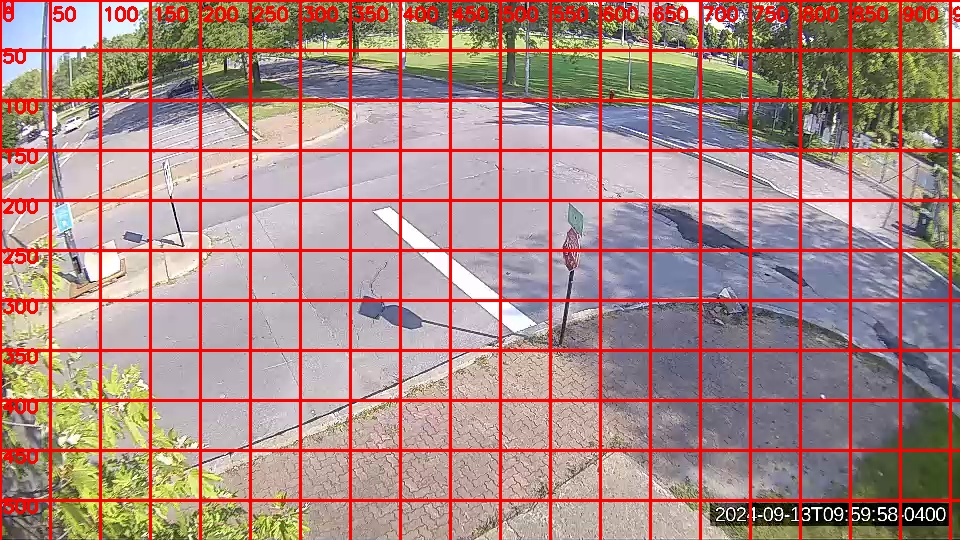

In [ ]:
# ✅ STEP 1: SETUP AND DRIVE MOUNT

# 1. Install required packages
!pip install ultralytics deep_sort_realtime opencv-python-headless

# 2. Mount Google Drive
from google.colab import drive
from datetime import datetime
import os
import cv2
import numpy as np
from IPython.display import Image, display

drive.mount('/content/drive')

# 3. Create working folder with timestamp
base_dir = '/content/drive/MyDrive/Learning/Vehicle-Counting'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
dev_folder = os.path.join(base_dir, f'DEV_{timestamp}')
os.makedirs(dev_folder, exist_ok=True)

# 4. Create Detection-frame folder inside DEV
frame_folder = os.path.join(dev_folder, 'Detection-frame')
os.makedirs(frame_folder, exist_ok=True)

# 5. Detect MP4 video in working folder
mp4_files = [f for f in os.listdir(base_dir) if f.endswith('.mp4')]
if not mp4_files:
    raise FileNotFoundError("❌ No MP4 video found in the directory.")

video_filename = mp4_files[0]
video_path = os.path.join(base_dir, video_filename)

# 6. Extract and save first frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if not ret:
    raise ValueError("❌ Failed to read frame from video.")

# Draw gridlines and X/Y coordinate labels on a copy of the first frame
grid_frame = frame.copy()
font = cv2.FONT_HERSHEY_SIMPLEX
for x in range(0, grid_frame.shape[1], 50):
    cv2.line(grid_frame, (x, 0), (x, grid_frame.shape[0]), (0, 0, 255), 2)
    cv2.putText(grid_frame, str(x), (x + 2, 20), font, 0.6, (0, 0, 255), 2)
for y in range(0, grid_frame.shape[0], 50):
    cv2.line(grid_frame, (0, y), (grid_frame.shape[1], y), (0, 0, 255), 2)
    cv2.putText(grid_frame, str(y), (2, y + 12), font, 0.6, (0, 0, 255), 2)

# Save with custom name
base_name = os.path.splitext(video_filename)[0]
frame_filename = f"{base_name}_FF.jpg"
frame_path = os.path.join(dev_folder, frame_filename)
cv2.imwrite(frame_path, grid_frame)
print(f"✅ First frame with grid saved at: {frame_path}")
display(Image(filename=frame_path))


Enter the 4 polygon points as x,y pairs (separated by space). Example: 150,100 600,80 620,400 180,420
Polygon points: 100,200 300,50 550,350 350,500
Enter line start and end points as x1,y1 x2,y2. Example: 260,100 600,400
Line points: 100,0 550,500
🖼 Preview with outline saved at: /content/drive/MyDrive/Learning/Vehicle-Counting/MIOP000936_2024_09_12-0728.00027_preview_outline.jpg


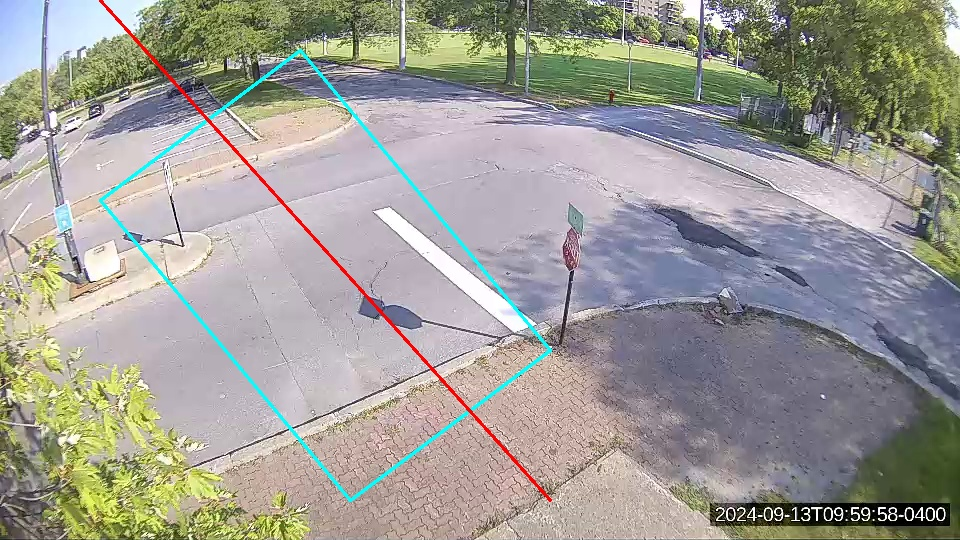

✅ Are you happy with the polygon and line? (yes/no): yes


In [ ]:
# ✅ STEP 2A: DRAW POLYGON AND LINE (PREVIEW ONLY)

while True:
    print("Enter the 4 polygon points as x,y pairs (separated by space). Example: 150,100 600,80 620,400 180,420")
    poly_input = input("Polygon points: ")
    poly_points = [tuple(map(int, pt.split(','))) for pt in poly_input.strip().split()]
    if len(poly_points) != 4:
        print("❌ Please enter exactly 4 points.")
        continue

    print("Enter line start and end points as x1,y1 x2,y2. Example: 260,100 600,400")
    line_input = input("Line points: ")
    try:
        p1_str, p2_str = line_input.strip().split()
        point1 = tuple(map(int, p1_str.split(',')))
        point2 = tuple(map(int, p2_str.split(',')))
    except:
        print("❌ Invalid line format. Try again.")
        continue

    preview_frame = frame.copy()
    cv2.polylines(preview_frame, [np.array(poly_points)], isClosed=True, color=(255, 255, 0), thickness=2)
    cv2.line(preview_frame, point1, point2, (0, 0, 255), 2)

    preview_path = os.path.join(video_dir, f"{base_name}_preview_outline.jpg")
    cv2.imwrite(preview_path, preview_frame)
    print(f"🖼 Preview with outline saved at: {preview_path}")
    display(Image(filename=preview_path))

    confirm_outline = input("✅ Are you happy with the polygon and line? (yes/no): ").strip().lower()
    if confirm_outline == 'yes':
        break



📸 Preview with zones saved at: /content/drive/MyDrive/Learning/Vehicle-Counting/MIOP000936_2024_09_12-0728.00027_preview_zones.jpg


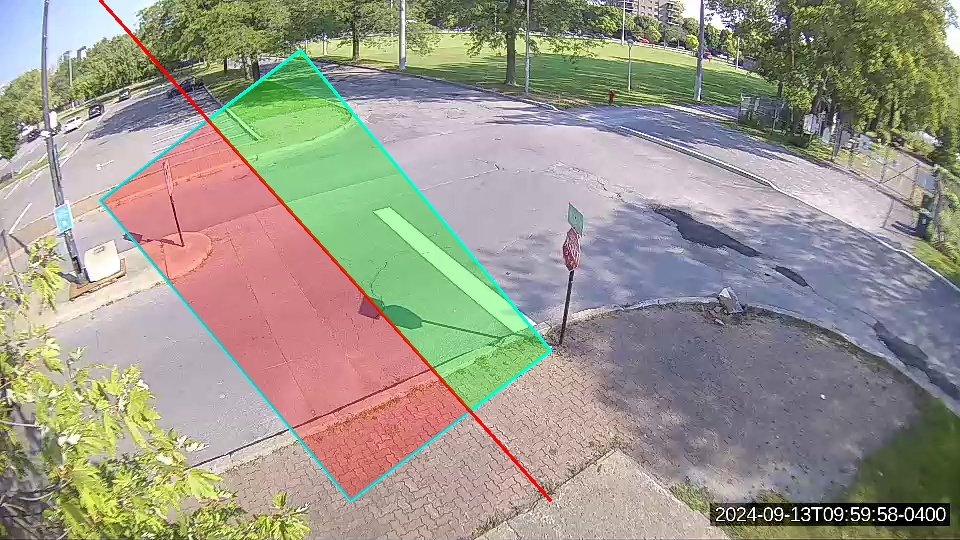

🟩 Is the GREEN zone the INSIDE of the parking lot? (yes/no): no
🔄 Preview updated and saved at: /content/drive/MyDrive/Learning/Vehicle-Counting/MIOP000936_2024_09_12-0728.00027_preview_zones.jpg


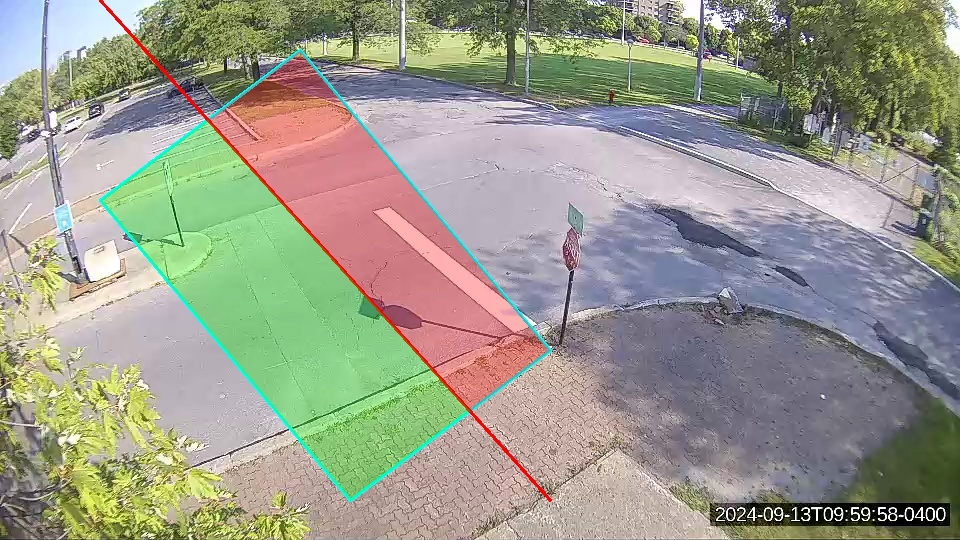

🟩 Is the GREEN zone the INSIDE of the parking lot? (yes/no): yes


In [ ]:
# ✅ STEP 2B: ASSIGN ZONES BASED ON LINE DIRECTION

# Compute normal to the line
zone_mask = np.zeros(preview_frame.shape[:2], dtype=np.uint8)
cv2.fillPoly(zone_mask, [np.array(poly_points)], 255)
dx = point2[0] - point1[0]
dy = point2[1] - point1[1]
length = max((dx**2 + dy**2)**0.5, 1)
normal = np.array([-dy / length, dx / length])

# Color zones for preview
preview_frame = frame.copy()
cv2.polylines(preview_frame, [np.array(poly_points)], isClosed=True, color=(255, 255, 0), thickness=2)
cv2.line(preview_frame, point1, point2, (0, 0, 255), 2)
overlay = preview_frame.copy()
for y in range(preview_frame.shape[0]):
    for x in range(preview_frame.shape[1]):
        if zone_mask[y, x]:
            vec = np.array([x - point1[0], y - point1[1]])
            if np.dot(vec, normal) > 0:
                overlay[y, x] = (0, 0, 255)  # red zone
            else:
                overlay[y, x] = (0, 255, 0)  # green zone

alpha = 0.3
preview_frame = cv2.addWeighted(overlay, alpha, preview_frame, 1 - alpha, 0)

zone_check_path = os.path.join(video_dir, f"{base_name}_preview_zones.jpg")
cv2.imwrite(zone_check_path, preview_frame)
print(f"📸 Preview with zones saved at: {zone_check_path}")
display(Image(filename=zone_check_path))
import time
time.sleep(0.5)

while True:
    zone_confirm = input("🟩 Is the GREEN zone the INSIDE of the parking lot? (yes/no): ").strip().lower()
    if zone_confirm == 'yes':
        break
    else:
        normal = -normal  # Flip zones

        # Redraw preview with updated zone assignment
        preview_frame = frame.copy()
        cv2.polylines(preview_frame, [np.array(poly_points)], isClosed=True, color=(255, 255, 0), thickness=2)
        cv2.line(preview_frame, point1, point2, (0, 0, 255), 2)
        overlay = preview_frame.copy()
        for y in range(preview_frame.shape[0]):
            for x in range(preview_frame.shape[1]):
                if zone_mask[y, x]:
                    vec = np.array([x - point1[0], y - point1[1]])
                    if np.dot(vec, normal) > 0:
                        overlay[y, x] = (0, 0, 255)  # red zone
                    else:
                        overlay[y, x] = (0, 255, 0)  # green zone

        preview_frame = cv2.addWeighted(overlay, alpha, preview_frame, 1 - alpha, 0)
        zone_check_path = os.path.join(video_dir, f"{base_name}_preview_zones.jpg")
        cv2.imwrite(zone_check_path, preview_frame)
        print(f"🔄 Preview updated and saved at: {zone_check_path}")
        display(Image(filename=zone_check_path))
        time.sleep(0.5)

roi_polygon = np.array(poly_points)


In [ ]:
# ✅ STEP 3: OBJECT DETECTION + TRACKING WITH YOLOv8 AND DEEPSORT

from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import pandas as pd

model = YOLO('yolov8n.pt')
tracker = DeepSort(max_age=30)

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_path = os.path.join(video_dir, f"{base_name}_annotated.mp4")
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

def side_of_line(pt, A, B):
    return (B[0] - A[0]) * (pt[1] - A[1]) - (B[1] - A[1]) * (pt[0] - A[0])

object_states = {}
log = []
trail_history = {}
frame_id = 0
FRAME_SKIP = 2
accepted_classes = [2, 5, 7]  # car, bus, truck

from tqdm.notebook import tqdm

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
progress_bar = tqdm(total=frame_count, desc="🔍 Processing frames", unit="frame")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_id += 1
    progress_bar.update(1)
    if frame_id % FRAME_SKIP != 0:
        continue

    timestamp = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0
    # Create mask from ROI polygon
    mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [roi_polygon], 255)
    roi = cv2.bitwise_and(frame, frame, mask=mask)
    results = model(roi, verbose=False)[0]
    detections = []
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        cls = int(box.cls[0])
        if cls in accepted_classes:
            detections.append(([x1, y1, x2 - x1, y2 - y1], conf, str(cls))) # Removed roi_top_left offset

    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        l, t, w, h = track.to_ltrb()
        cx, cy = int((l + l + w) / 2), int((t + t + h) / 2)

        if track_id not in object_states:
            object_states[track_id] = [(cx, cy)]
            trail_history[track_id] = [(cx, cy)]
        else:
            object_states[track_id].append((cx, cy))
            trail_history[track_id].append((cx, cy))

        cv2.rectangle(frame, (int(l), int(t)), (int(l + w), int(t + h)), (0, 255, 255), 2)
        cv2.putText(frame, f"ID {track_id}", (int(l), int(t - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

        # Draw trail
        for i in range(1, len(trail_history[track_id])):
            cv2.line(frame, trail_history[track_id][i - 1], trail_history[track_id][i], (0, 180, 255), 2)

        if len(object_states[track_id]) >= 2:
            prev = object_states[track_id][0]  # where it started
            curr = object_states[track_id][-1]  # where it ended

            if cv2.pointPolygonTest(roi_polygon, prev, False) >= 0 and cv2.pointPolygonTest(roi_polygon, curr, False) >= 0:
                vec_prev = np.array([prev[0] - point1[0], prev[1] - point1[1]])
                vec_curr = np.array([curr[0] - point1[0], curr[1] - point1[1]])
                normal = np.array([-dy / length, dx / length])

                zone_start = 'INSIDE' if np.dot(vec_prev, normal) <= 0 else 'OUTSIDE'
                zone_end = 'INSIDE' if np.dot(vec_curr, normal) <= 0 else 'OUTSIDE'

                if zone_start != zone_end:
                    direction = 'exiting' if zone_start == 'INSIDE' else 'entering'
                    minutes = int(timestamp // 60)
                    seconds = int(timestamp % 60)
                    vehicle_type = {2: 'car', 5: 'bus', 7: 'truck'}.get(cls, 'unknown')
                    log.append((timestamp, track_id, direction, vehicle_type))
                    # df_partial = pd.DataFrame([(timestamp, track_id, direction, vehicle_type)], columns=["timestamp_sec", "track_id", "movement", "vehicle_type"])
                    # df_partial.to_csv(csv_path, mode='a', index=False, header=not os.path.exists(csv_path))

                    # Save detection frame
                    detection_folder = os.path.join(video_dir, "Detection-frame")
                    os.makedirs(detection_folder, exist_ok=True)
                    detection_filename = f"{base_name}_ID{track_id}.jpg"
                    detection_path = os.path.join(detection_folder, detection_filename)
                    cv2.imwrite(detection_path, frame)

                    print(f"✔ Vehicle ID {track_id} ({vehicle_type}) went from {zone_start} to {zone_end} ({direction}) at {minutes}m{seconds:02d}s")
                    cv2.putText(frame, f"{direction} @ {timestamp:.1f}s", (int(l), int(t + h + 20)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                    object_states[track_id] = []

    cv2.line(frame, point1, point2, (0, 0, 255), 2)
    cv2.polylines(frame, [roi_polygon], isClosed=True, color=(255, 255, 0), thickness=2)

    out.write(frame)

progress_bar.close()
cap.release()
out.release()

# Save log
from collections import Counter
movement_counts = Counter([entry[2] for entry in log])
print("\n📊 Summary of vehicle movements:")
for direction, count in movement_counts.items():
    print(f"- {direction.capitalize()}: {count} vehicle(s)")

# Final save (overwrite for full consistency)
# Full DataFrame already handled above
# df.to_csv(csv_path, index=False) # This line will cause error as df is not defined in this cell.
print(f"✅ Detection complete. Log will be saved to CSV after the next step.")
print(f"🎥 Annotated video saved to: {output_path}")

🔍 Processing frames:   0%|          | 0/54000 [00:00<?, ?frame/s]

✔ Vehicle ID 4 (unknown) went from INSIDE to OUTSIDE (exiting) at 0m43s
✔ Vehicle ID 8 (car) went from OUTSIDE to INSIDE (entering) at 1m53s
✔ Vehicle ID 14 (car) went from OUTSIDE to INSIDE (entering) at 3m01s
✔ Vehicle ID 13 (car) went from OUTSIDE to INSIDE (entering) at 3m01s
✔ Vehicle ID 16 (car) went from INSIDE to OUTSIDE (exiting) at 7m12s
✔ Vehicle ID 17 (car) went from OUTSIDE to INSIDE (entering) at 10m39s
✔ Vehicle ID 19 (car) went from OUTSIDE to INSIDE (entering) at 11m01s
✔ Vehicle ID 21 (car) went from OUTSIDE to INSIDE (entering) at 11m02s
✔ Vehicle ID 19 (car) went from INSIDE to OUTSIDE (exiting) at 11m05s
✔ Vehicle ID 26 (car) went from OUTSIDE to INSIDE (entering) at 11m26s
✔ Vehicle ID 33 (car) went from OUTSIDE to INSIDE (entering) at 13m20s
✔ Vehicle ID 34 (car) went from OUTSIDE to INSIDE (entering) at 14m30s
✔ Vehicle ID 37 (car) went from OUTSIDE to INSIDE (entering) at 15m31s
✔ Vehicle ID 39 (car) went from OUTSIDE to INSIDE (entering) at 15m55s
✔ Vehicle ID

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-26-1192077880.py", line 47, in <cell line: 0>
    results = model(roi, verbose=False)[0]
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 185, in __call__
    return self.predict(source, stream, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 555, in predict
    return self.predictor.predict_cli(source=source) if is_cli else self.predictor(source=source, stream=stream)
                                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/predictor.py", line 227, in __call__
    return list(self

TypeError: object of type 'NoneType' has no len()